# Demo for CNN

### Import GradLab modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core.engine import Tensor
from core.nn import Sequential, Linear, ReLU, Conv1D
from core.optim import Adam

### Load & Prepare MNIST Dataset

We load the **Fashion-MNIST dataset**, which contains 28×28 grayscale images of clothing items. To make training faster, we use only 1,000 training images and 200 test images. Each image is reshaped, so that each row becomes a sequence of 28 numbers, with 28 channels, which prepares the data for a **Conv1D network**.

The labels are **one-hot encoded** into 10-dimensional vectors, one for each clothing type. This format makes them compatible with common loss functions (i.e. cross-entropy), and the reshaped images allow the convolutional layers to process the data correctly during training.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

n_train = 1000
n_test = 200

# Normalize to [0,1] and flatten to vectors
x_train, y_train = x_train[:n_train], y_train[:n_train]
x_test, y_test = x_test[:n_test], y_test[:n_test]
x_train = x_train.reshape(-1, 28, 28).transpose(2,1,0)
x_test = x_test.reshape(-1, 28, 28).transpose(2,1,0)

# One-hot encode labels
num_classes = 10
y_train_oh = np.eye(num_classes)[y_train].T.astype(np.float32)
y_test_oh = np.eye(num_classes)[y_test].T.astype(np.float32)

### Model and Optimiser Definition

We define a simple **neural network model** using a sequence of layers. The first layer is a **Conv1D layer** with 28 input channels (one for each row of the image), 16 output channels, and a kernel size of 3, which extracts local patterns from each row. A **ReLU activation** follows to introduce non-linearity. The output is then flattened and passed through a **Linear (fully connected) layer** with 64 units, followed by another ReLU activation.

Finally, the model outputs a vector of length 10 using a **Linear layer**, corresponding to the 10 clothing categories. We use the **Adam optimizer** to update the model's parameters during training, which adapts the learning rate for each parameter to speed up convergence and improve performance.

In [3]:
model = Sequential(
    Conv1D(in_channels=28, out_channels=16, kernel_size=3),
    ReLU(),
    Linear(16*26, 64),
    ReLU(),
    Linear(64, num_classes)
)

optimizer = Adam(model.parameters())

### Loss Definition

The **softmax function** converts the raw model outputs (logits) into probabilities that sum to one across each class. It works by exponentiating the logits (after subtracting the maximum value for numerical stability) and then normalising by the total sum. This makes the outputs interpretable as probabilities for classification tasks. In backpropagation, the Jacobian of softmax is complex, so for simplicity this implementation just propagates gradients directly, which is enough when paired with cross-entropy loss.  

The **cross-entropy loss** measures how well the predicted probability distribution matches the true labels (provided in one-hot form). It computes the negative log likelihood of the correct classes and averages this across the batch. The backward pass provides gradients of the loss with respect to the predicted probabilities, which simplifies to `(pred - target) / batch_size`. This pairing of softmax and cross-entropy is widely used in training classification models.

In [4]:
def softmax(x: Tensor) -> Tensor:
    """
    Returns the softmax of a Tensor

    Args:
        x: a tensor that contains the unnormalised logits (raw model ouput)
    """
    exps = np.exp(x.data - np.max(x.data, axis=0, keepdims=True))
    probs = exps / np.sum(exps, axis=0, keepdims=True)
    out = Tensor(probs, requires_grad=x.requires_grad)

    def _backward():
        """
        Returns the local gradient contribution 
        """
        if x.requires_grad:
            # Jacobian of softmax is messy; for training we usually combine with CE
            # Here we just propagate grads as-is (educational, not optimized)
            x.grad += out.grad
    out._backward = _backward
    out._prev = {x}
    return out

def cross_entropy_loss(pred: Tensor, target: np.ndarray) -> Tensor:
    """
    Computes the Cross Entropy loss
    
    Args:
        pred: a tensor that contains the predicted probability distribution (predicted labels)
        target: one-hot np.ndarray that holds the true probaility distribution (actual labels)
    """
    m = target.shape[1]

    log_likelihood = -np.log(pred.data + 1e-9) * target
    loss_val = np.sum(log_likelihood) / m
    loss = Tensor(loss_val, requires_grad=True)

    def _backward():
        """
        Returns the local gradient contribution 
        """
        if pred.requires_grad:
            pred.grad += (pred.data - target) / m
    loss._backward = _backward
    loss._prev = {pred}
    return loss

### Training Loop

This is the **training loop** for the Conv1D network. We train for 100 epochs with a batch size of 64. At the start of each epoch, the training data is **shuffled** to prevent the model from learning patterns based on the order of samples. Each batch is converted to a `Tensor` for forward and backward computations. The model processes the batch by first applying the **Conv1D layer**, flattening the output, and then passing it through the remaining **fully connected layers**. The predictions are converted to probabilities using **softmax**, and the **cross-entropy loss** measures the difference between the predicted labels and actual labels.

During the backward pass, gradients are computed with `loss.backward()`, and the **Adam optimizer** updates the model parameters.

In [ ]:
epochs = 100
batch_size = 64

# Empty lists for storing datapoints of each variable for plotting
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    perm = np.random.permutation(x_train.shape[2])
    x_train_shuffled = x_train[:, :, perm]
    y_train_shuffled = y_train_oh[:, perm]

    epoch_losses = []
    for i in range(0, x_train.shape[2], batch_size):
        xb = Tensor(x_train_shuffled[:, :, i:i+batch_size], requires_grad=False)
        yb = y_train_shuffled[:, i:i+batch_size]

        conv_out = model.layers[0](xb)
        flat = conv_out.data.reshape(-1, conv_out.data.shape[-1])
        flat_tensor = Tensor(flat, requires_grad=conv_out.requires_grad)
        # feed forward remaining layers
        logits = Sequential(*model.layers[1:])(flat_tensor)

        probs = softmax(logits)
        loss = cross_entropy_loss(probs, yb)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data)
    avg_loss = np.mean(epoch_losses)

    # Evaluate accuracy
    test_conv = model.layers[0](Tensor(x_test, requires_grad=False))
    test_flat = test_conv.data.reshape(-1, test_conv.data.shape[-1])
    test_logits = Sequential(*model.layers[1:])(Tensor(test_flat, requires_grad=False))
    test_probs = softmax(test_logits)
    test_preds = np.argmax(test_probs.data, axis=0)
    acc = np.mean(test_preds == y_test)

    # Append datapoints (average loss & test accuracy) for each epoch
    train_losses.append(avg_loss)
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Acc: {acc:.4f}")

Epoch 1/100, Loss: 2.0264, Test Acc: 0.5850
Epoch 2/100, Loss: 1.3112, Test Acc: 0.6650
Epoch 3/100, Loss: 0.8986, Test Acc: 0.6750
Epoch 4/100, Loss: 0.7545, Test Acc: 0.7350
Epoch 5/100, Loss: 0.6617, Test Acc: 0.7450
Epoch 6/100, Loss: 0.6239, Test Acc: 0.7500
Epoch 7/100, Loss: 0.5764, Test Acc: 0.7650
Epoch 8/100, Loss: 0.5334, Test Acc: 0.7550
Epoch 9/100, Loss: 0.5199, Test Acc: 0.7700
Epoch 10/100, Loss: 0.5015, Test Acc: 0.7750
Epoch 11/100, Loss: 0.4858, Test Acc: 0.7850
Epoch 12/100, Loss: 0.4526, Test Acc: 0.7500
Epoch 13/100, Loss: 0.4435, Test Acc: 0.7700
Epoch 14/100, Loss: 0.4283, Test Acc: 0.7900
Epoch 15/100, Loss: 0.4018, Test Acc: 0.7550
Epoch 16/100, Loss: 0.4007, Test Acc: 0.8050
Epoch 17/100, Loss: 0.3866, Test Acc: 0.7900
Epoch 18/100, Loss: 0.3704, Test Acc: 0.7950
Epoch 19/100, Loss: 0.3530, Test Acc: 0.7850
Epoch 20/100, Loss: 0.3443, Test Acc: 0.8000
Epoch 21/100, Loss: 0.3193, Test Acc: 0.8000
Epoch 22/100, Loss: 0.3215, Test Acc: 0.7850
Epoch 23/100, Loss:

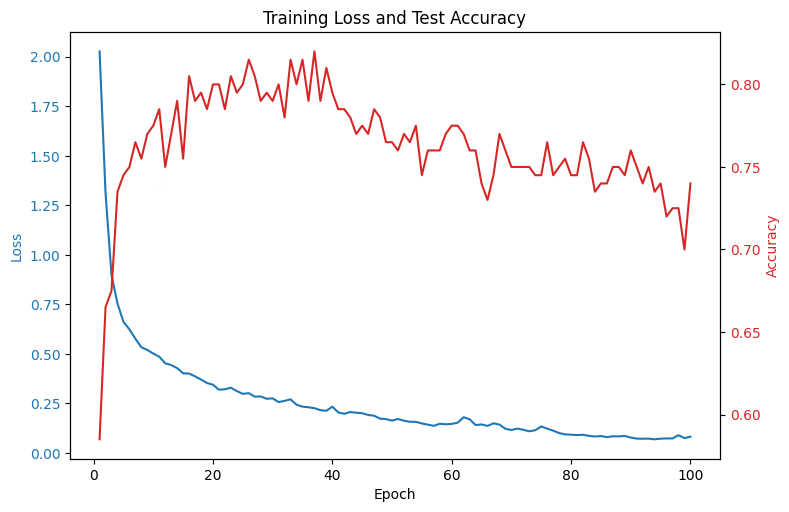

In [6]:
# Plot Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, epochs+1), train_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, epochs+1), test_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Test Accuracy')
plt.show()

### Testing MLP model

Random Sample Prediction -> True: 5, Pred: 7
Model Certainty: 0.9836995601654053


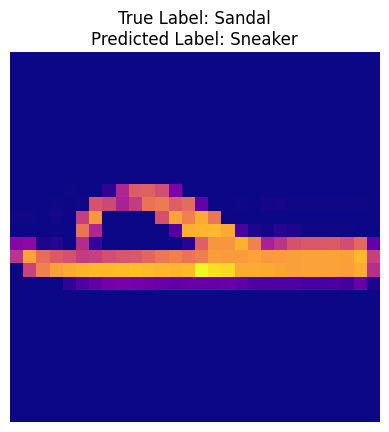

In [7]:
idx = np.random.randint(0, x_test.shape[2])
x_sample = Tensor(x_test[:, :, idx:idx+1], requires_grad=False)
conv_out = model.layers[0](x_sample)
flat = conv_out.data.reshape(-1, 1)
logits = Sequential(*model.layers[1:])(Tensor(flat, requires_grad=False))
probs = softmax(logits)

pred_label = int(np.argmax(probs.data))
true_label = int(y_test[idx])

print(f"Random Sample Prediction -> True: {true_label}, Pred: {pred_label}\nModel Certainty: {np.max(probs.data)}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.imshow(x_test[:, :, idx].T, cmap="plasma")
plt.title(f"True Label: {class_names[true_label]}\nPredicted Label: {class_names[pred_label]}")
plt.axis("off")
plt.show()